## Fake News Detection

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

c:\Users\david\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import re
import string

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, matthews_corrcoef, precision_score, recall_score

In [7]:
import os
os.getcwd()

'c:\\Users\\david\\Desktop'

In [8]:
abs_path = 'c:/Users/david/Desktop/archive/'
fake = pd.read_csv(abs_path + "Fake.csv")
true = pd.read_csv(abs_path + "True.csv")
print('Fake news data: ',fake.shape)
print('True news data:',true.shape)

Fake news data:  (23481, 4)
True news data: (21417, 4)


In [9]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [10]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [11]:
fake['class'] = 0
true['class'] = 1

In [12]:
data = pd.concat([fake, true], axis=0)

In [13]:
data = data.sample(frac=1)
data.reset_index(inplace=True) 
data.drop(["index"], axis=1, inplace=True)

In [14]:
def process_news(text):
    text = text.lower()
    text = re.sub(r'https?://S+ | www\.\S+', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub('\[.*?\]', '', text)
    words=[]
    for i in text:
        if i not in string.punctuation:
            words.append(i)
    return ''.join(words)


data['text'] = data['text'].apply(process_news)
data['text'].head()

0    black lives matter the group that many believe...
1    the video below is one of the highlights from ...
2    reuters  president donald trump’s nominee to r...
3    with reince priebus out as white house chief o...
4    on january 29 the family of lavoy finicum rele...
Name: text, dtype: object

In [15]:
x = data['text']
y = data['class']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

In [16]:
vector = TfidfVectorizer()
xtrain = vector.fit_transform(xtrain)
xtest = vector.transform(xtest)

In [17]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
#     'K-NN': KNeighborsClassifier(),  # This will take too much time, it best not to use this method
#     'SVM': SVC(),  # It also take around additional 30min to run
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Classifier' : GradientBoostingClassifier(random_state=0)
}

In [19]:
import time

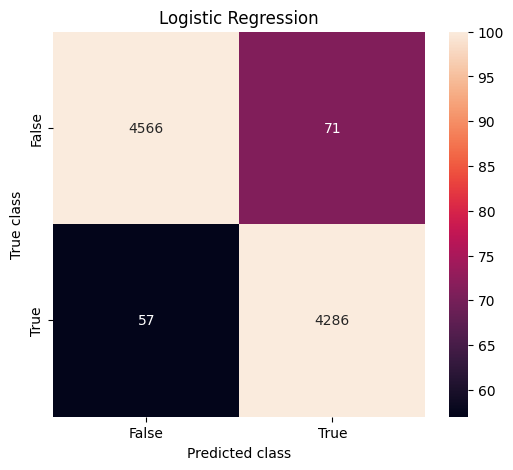

Accuracy:  0.9857461024498887
Precision:  0.9837043837502869
Recall:  0.9868754317292194
F1-Score:  0.9852873563218391
Matthews correlation coefficient:  0.9714692631584703
Time taken(in sec):  7.63
---------------------------------------------------------------------- 



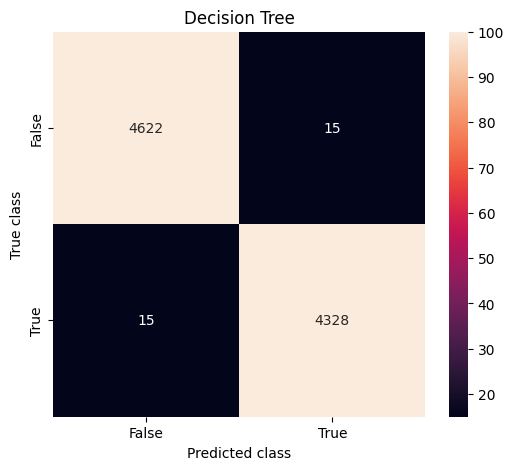

Accuracy:  0.9966592427616926
Precision:  0.9965461662445314
Recall:  0.9965461662445314
F1-Score:  0.9965461662445314
Matthews correlation coefficient:  0.9933113161259203
Time taken(in sec):  130.75
---------------------------------------------------------------------- 



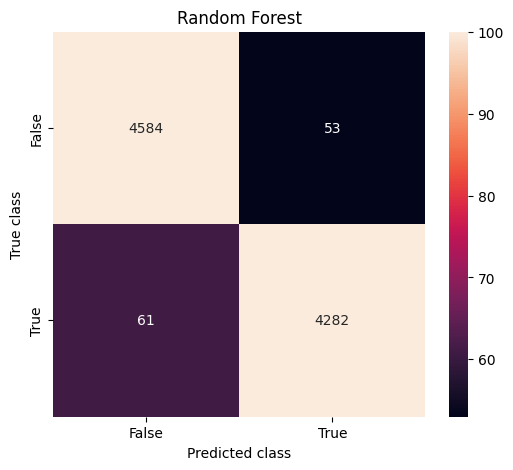

Accuracy:  0.987305122494432
Precision:  0.9877739331026528
Recall:  0.9859544093944278
F1-Score:  0.9868633325651072
Matthews correlation coefficient:  0.9745830674034806
Time taken(in sec):  435.8
---------------------------------------------------------------------- 



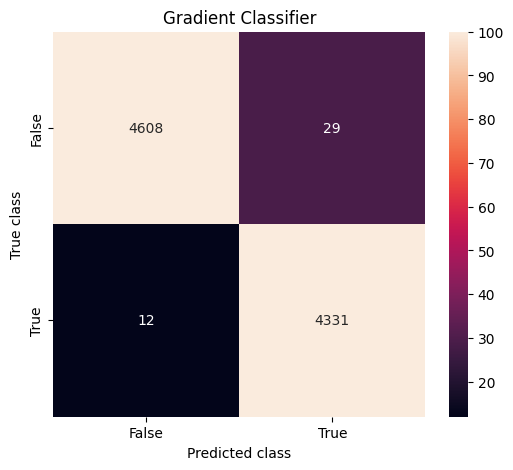

Accuracy:  0.99543429844098
Precision:  0.993348623853211
Recall:  0.9972369329956251
F1-Score:  0.9952889808112144
Matthews correlation coefficient:  0.990867048573789
Time taken(in sec):  1160.47
---------------------------------------------------------------------- 



In [20]:
for name, model in models.items():
    start = time.time()
    model.fit(xtrain, ytrain)
    predict = model.predict(xtest)
    
    LABELS = ['False', 'True']
    conf_matrix = confusion_matrix(ytest, predict)
    plt.figure(figsize =(6,5))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, vmax = 100, annot = True, fmt ="d");
    plt.title(f'{name}')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print("Accuracy: ", accuracy_score(ytest, predict))
    print("Precision: ", precision_score(ytest, predict))
    print("Recall: ", recall_score(ytest, predict))
    print("F1-Score: ", f1_score(ytest, predict))
    print("Matthews correlation coefficient: ", matthews_corrcoef(ytest, predict))
    end = time.time()
    print("Time taken(in sec): ",round(end-start, 2))
    print('-' * 70, '\n')